In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import os
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import rotate
import imutils
import cv2
import matplotlib as mpl
from sklearn.metrics import mean_squared_error, r2_score

In [50]:
run_name = 'baseline'
plots_path = f'../results/{run_name}/plots/'

create_dataset = False
process_dataset = False

In [51]:
trees = pd.read_csv(f'../data/reforestree/field_data.csv')

# Plot Carbon Distribution

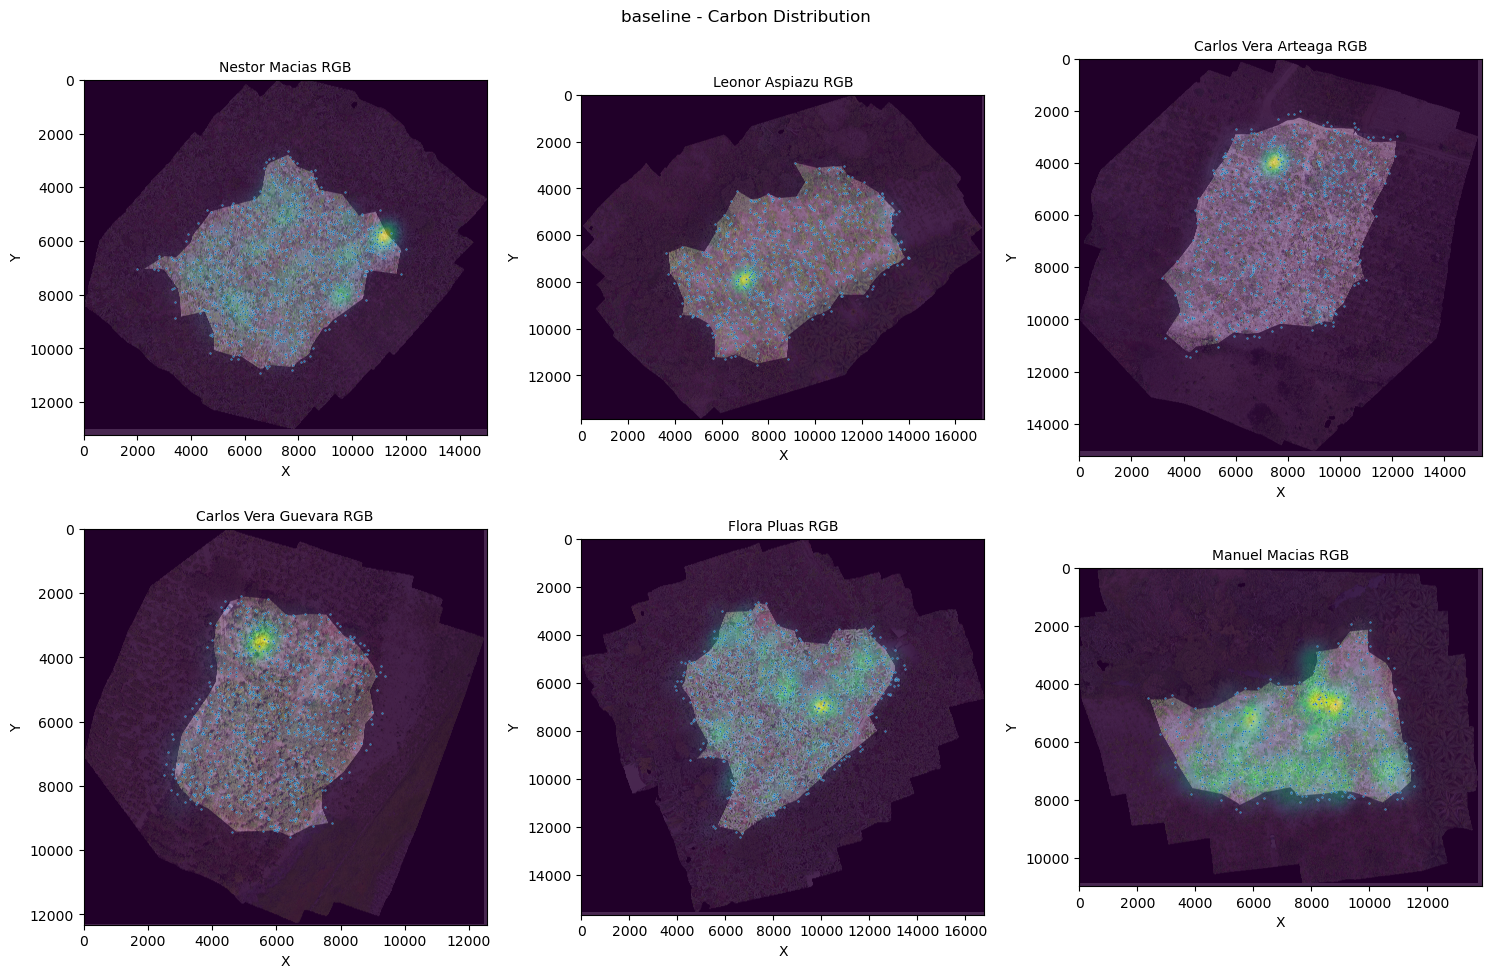

In [25]:
if run_name != "benchmark" and create_dataset:
    plt.ioff()
    fig, axs = plt.subplots(2, 3, figsize=(15,10))
    fig.suptitle(f"{run_name} - Carbon Distribution")

    for site, ax in zip(trees.site.unique(), axs.flat):
        carbon_distribution = np.load('../data/dataset/sites/{}_carbon.npy'.format(site))
        image = cv2.imread('../data/dataset/sites/{}_image.png'.format(site))
        image = np.array(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        image_original = cv2.imread('../data/reforestree/wwf_ecuador/RGB Orthomosaics/{}.tif'.format(site))
        image_original = np.array(cv2.cvtColor(image_original, cv2.COLOR_BGR2RGB))

        ax.imshow(image_original)
        ax.imshow(image, alpha=0.7)
        ax.imshow(carbon_distribution, alpha=0.5)
        sns.scatterplot(data=trees[trees.site == site], x="X", y="Y", legend=False, s=2, ax=ax)
        ax.set_title(site, fontsize=10)

    fig.tight_layout(pad=1)
    plt.savefig(plots_path + "carbon_distribution.pdf", dpi=300)
    plt.close()

# Load Images

In [52]:
# get image shapes
images = {}
image_shapes = {}
carbon_distributions = {}
for site in tqdm(trees.site.unique()):
    path = '../data/dataset/sites/{}_image.png'.format(site)
    img = cv2.imread(path)
    img = np.array(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    images[site] = img
    image_shapes[site] = img.shape

    carbon_distribution = np.load('../data/dataset/sites/{}_carbon.npy'.format(site))
    carbon_distributions[site] = carbon_distribution

100%|██████████| 6/6 [00:18<00:00,  3.14s/it]


# Prepare patches

In [53]:
if run_name != "benchmark":
    patches = pd.read_csv(f'../results/{run_name}/csv/predictions.csv', index_col=0)
    patches = patches.rename(columns={"patch size": "patch_size"})
    patches = patches.drop(columns=patches.columns[0], axis=1)
    a = [np.flip(eval(site_index))*patch_size for site_index, patch_size in zip(patches.site_index, patches.patch_size)]
    b = [np.array([a[0], a[1] + patch_size]) for a, patch_size in zip(a, patches.patch_size)]
    c = [np.array([a[0] + patch_size, a[1] + patch_size]) for a, patch_size in zip(a, patches.patch_size)]
    d = [np.array([a[0] + patch_size, a[1]]) for a, patch_size in zip(a, patches.patch_size)]
    vertices = np.moveaxis(np.stack((a,b,c,d)), 0, 1).tolist()
    patches["vertices"] = vertices
    
    vertices_transformed_array = []
    for idx, patch in patches.iterrows():
        angle = np.deg2rad(patch.rotation)
        A = np.array([[np.cos(angle), - np.sin(angle)], [np.sin(angle), np.cos(angle)]])
        h = image_shapes[patch.site][0]
        w = image_shapes[patch.site][1]
        offset1 = np.array([w, h])
        w2 = int(np.dot(offset1, np.array([np.cos(angle), np.sin(angle)])))
        h2 = int(np.dot(offset1, np.array([np.sin(angle), np.cos(angle)])))
        offset2 = np.array([w2, h2])
        vertices_transformed = [np.dot(A, coordinate - 0.5 * offset1) + 0.5 * offset1 for coordinate in patch.vertices]
        vertices_transformed_array.append(np.rint(vertices_transformed).astype(int))

    patches["vertices_transformed"] = vertices_transformed_array

# Prepare Benchmark

In [43]:
if run_name == "benchmark":
    benchmark_bb = pd.read_csv('../data/dataset/benchmark_dataset.csv', index_col=0)
    benchmark_bb['vertices_transformed'] = [[
        [bb.Xmin, bb.Ymin], 
        [bb.Xmax, bb.Ymin], 
        [bb.Xmax, bb.Ymax], 
        [bb.Xmin, bb.Ymax]]
        for idx, bb in benchmark_bb.iterrows()]
    benchmark_bb['rotation'] = np.zeros(benchmark_bb.shape[0])
    predictions = []
    for site in benchmark_bb.site.unique():
        predictions_site = pd.read_csv(f'../results/{run_name}/csv/predictions/predictions_{site}.csv', index_col=0)
        predictions.append(predictions_site.preds.values)
    predictions = [item for sublist in predictions for item in sublist]
    benchmark_bb['predictions'] = predictions
    benchmark_bb.to_csv(f'../results/{run_name}/csv/predictions.csv')
    patches = benchmark_bb

# Run Analysis

In [71]:
if run_name != "benchmark" and process_dataset:
    plots_path = '../results/baseline/plots/'

    if not os.path.exists(plots_path + 'patches/'):
        os.makedirs(plots_path + 'patches/')

    for site in patches.site.unique():
        plt.ioff()
        
        patches_site = patches[patches.site == site]
        fig, axs = plt.subplots(1, 3, figsize=(15,5))
        fig.suptitle(f"{run_name} - {site} - Patches")
        axs = axs.flat
        for idx, angle_deg in enumerate(patches_site.rotation.unique()):
            axs[idx].imshow(images[site])
            axs[idx].imshow(carbon_distributions[site], alpha=0.5)
            for idx_patch, patch in patches_site[patches_site.rotation == angle_deg].iterrows():
                vertices = np.array(patch.vertices_transformed)
                patch_rec = plt.Rectangle(vertices[0], np.linalg.norm(vertices[1] - vertices[0]), np.linalg.norm(vertices[3] - vertices[0]), angle=patch.rotation, linewidth=0.5, edgecolor='w', facecolor='none')
                axs[idx].add_patch(patch_rec)
        plt.savefig(plots_path + 'patches/' + f"patches_{site}.pdf", dpi=300)
        plt.close()

In [41]:
# option to use global color scale
cmap = mpl.cm.get_cmap('viridis')
norm = mpl.colors.Normalize(vmin=0.0001, vmax=np.percentile(patches.carbon, 90))
cmap.set_over('salmon')
cmap.set_under('white')

In [44]:
for site in patches.site.unique():
    plt.ioff()
    patches_site = patches[(patches.site == site) & (patches.rotation == 0)]

    '''
    cmap = mpl.cm.get_cmap('viridis')
    norm = mpl.colors.Normalize(vmin=0.0001, vmax=np.percentile(patches_site.carbon, 90))
    cmap.set_over('salmon')
    cmap.set_under('white')
    '''

    fig, axs = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle(f"{run_name} - {site}")

    angle_deg = 0
    axs = axs.flat
    axs[0].imshow(images[site])
    for idx_patch, patch in patches_site.iterrows():
        vertices = np.array(patch.vertices_transformed)
        patch_rec = plt.Rectangle(vertices[0], np.linalg.norm(vertices[1] - vertices[0]), np.linalg.norm(vertices[3] - vertices[0]), angle=0, linewidth=0.5, edgecolor='w', facecolor=cmap(norm(patch.carbon)), alpha=1)
        axs[0].add_patch(patch_rec)
        axs[0].set_title('Tree distribution', fontsize=10)
    axs[1].imshow(images[site])
    for idx_patch, patch in patches_site.iterrows():
        vertices = np.array(patch.vertices_transformed)
        patch_rec = plt.Rectangle(vertices[0], np.linalg.norm(vertices[1] - vertices[0]), np.linalg.norm(vertices[3] - vertices[0]), angle=0, linewidth=0.5, edgecolor='w', facecolor=cmap(norm(patch.predictions)), alpha=1)
        axs[1].add_patch(patch_rec)
        axs[1].set_title('Prediction', fontsize=10)

    divider = make_axes_locatable(axs[0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)

    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
    plt.savefig(plots_path + 'predictions/' + f"predictions_{site}.pdf", dpi=300)
    plt.close()

In [45]:
for site in patches.site.unique():
    plt.ioff()
    patches_site = patches[(patches.site == site) & (patches.rotation == 0)]

    '''
    cmap = mpl.cm.get_cmap('viridis')
    norm = mpl.colors.Normalize(vmin=0.0001, vmax=np.percentile(patches_site.carbon, 90))
    cmap.set_over('salmon')
    cmap.set_under('white')
    '''
    
    patches_site = patches_site[['carbon', 'predictions']].copy()
    patches_site = patches_site.sort_values(by='carbon', ascending=False)

    d = int(np.ceil(np.sqrt(patches_site.shape[0])))
    true_values = patches_site.carbon.values.copy()
    true_values.resize((d,d))
    predictions = patches_site.predictions.values.copy()
    predictions.resize((d,d))

    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    fig.suptitle(f"{run_name} - {site}")

    axs = axs.flat
    im_0 = axs[0].pcolormesh(true_values, norm=norm, cmap=cmap)
    axs[0].set_title('Target - Carbon', fontsize=10)
    axs[0].invert_yaxis()
    axs[0].set_aspect('equal', adjustable='box')
    im_1 = axs[1].pcolormesh(predictions, norm=norm, cmap=cmap)
    axs[1].set_title('Prediction - Carbon', fontsize=10)
    axs[1].invert_yaxis()
    axs[1].set_aspect('equal', adjustable='box')

    divider = make_axes_locatable(axs[0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)

    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
    plt.savefig(plots_path + 'predictions/' + f"predictions_sorted_{site}.pdf", dpi=300)
    plt.close()

In [72]:
sns.set_theme()
for site in patches.site.unique():
    plt.ioff()
    patches_site = patches[(patches.site == site) & (patches.rotation == 0)]
    plt.hist(patches_site.carbon, bins=np.arange(0,20,1), alpha=0.6)
    plt.hist(patches_site.predictions, bins=np.arange(0,20,1), alpha=0.6)
    plt.legend(['target', 'prediction'])
    plt.title(f'{run_name} - {site} - Histogram ')
    plt.xlabel('Carbon')
    plt.savefig(plots_path + 'predictions/' + f"predictions_hist_{site}.pdf", dpi=300)
    plt.close()

# Metrics

In [47]:
metrics = []
for site in patches.site.unique():
    patches_site = patches[(patches.site == site) & (patches.rotation == 0)]

    if run_name != "benchmark":
        patch_size = patches.patch_size.values[0]
    else:
        patch_size = 0

    rotations = patches.rotation.unique()
    nr_patches_0 = patches_site.shape[0]

    sum_carbon = np.sum(trees[trees.site == site].carbon)
    sum_target = np.sum(patches_site.carbon)
    sum_prediction = np.sum(patches_site.predictions)

    mean_target = np.mean(patches_site.carbon)
    mean_prediction = np.mean(patches_site.predictions)

    mse = mean_squared_error(patches_site.carbon, patches_site.predictions)
    rmse = mean_squared_error(patches_site.carbon, patches_site.predictions, squared=False)
    r2 = r2_score(patches_site.carbon, patches_site.predictions)
    
    metrics.append([run_name, site, patch_size, rotations, nr_patches_0, sum_carbon, sum_target, sum_prediction, mean_target, mean_prediction, mse, rmse, r2])

metrics_pd = pd.DataFrame(metrics, columns=
    ['run_name', 'site', 'patch_size', 'rotations', 'nr_patches_0', 'sum_carbon', 'sum_target', 'sum_prediction', 'mean_target', 'mean_prediction', 'mse', 'rmse', 'r2'])
metrics_pd.to_csv(f'../results/{run_name}/csv/metrics.csv')

In [48]:
metrics_pd

,run_name,site,patch_size,rotations,nr_patches_0,sum_carbon,sum_target,sum_prediction,mean_target,mean_prediction,mse,rmse,r2
0,benchmark,Carlos Vera Guevara RGB,0,[0.0],397,5830.613502,1406.096038,997.373274,3.541804,2.512275,33.545506,5.791848,-0.418132
1,benchmark,Carlos Vera Arteaga RGB,0,[0.0],203,3034.612520,1049.284905,370.993121,5.168891,1.827552,82.129009,9.062506,-0.374568
2,benchmark,Flora Pluas RGB,0,[0.0],201,4763.539027,1418.303976,792.481644,7.056239,3.942695,536.607532,23.164791,-0.044209
3,benchmark,Leonor Aspiazu RGB,0,[0.0],296,3198.447545,2113.389110,1503.936037,7.139828,5.080865,875.953918,29.596519,-0.050881
4,benchmark,Manuel Macias RGB,0,[0.0],139,1097.447199,563.714289,268.488373,4.055498,1.931571,20.905715,4.572277,-2.971076
5,benchmark,Nestor Macias RGB,0,[0.0],328,5792.727929,1349.290774,448.504701,4.113691,1.367392,86.417943,9.296125,-0.202854


# Losses

In [69]:
for site in patches.site.unique():
    losses = pd.read_csv(f'../results/{run_name}/csv/losses/losses_{site}.csv', index_col=0)
    plt.ioff()
    plt.plot(losses.epoch, losses.train_loss)
    plt.plot(losses.epoch, losses.val_loss)
    plt.title(f'{run_name} - {site} - Losses')
    plt.xlabel('Epoch(s)')
    plt.ylabel('Loss [MSE]')
    endrange = (np.max(losses.epoch) // 5) + 1
    plt.xticks(range(0, endrange * 5, 5))
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(f'../results/{run_name}/plots/losses/train_val_results_{site}.pdf', dpi=300)
    plt.close()